# **Anvil cloud feedbacks in RCEMIP**

This notebook can be used to generate to read and manipulate the data used in Sokol et al. (2024) and to generate the figures in that paper.

Last update: Feb 9, 2024 <br>

In [53]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import warnings
warnings.filterwarnings('ignore')

# Load data
This dataset contains IWP-resolved cloud fraction ($f(IWP)$), radiative effects (SW, LW, & net; $C(IWP)$), and other derived statistics for each RCEMIP cloud-resolving model for three different surface temperatures. It also contains observed $f(IWP)$ for the tropical West Pacific for three different satellite retrieval prodcuts.

Note: the "fwp" (frozen water path) variable in this dataset is what is reffered to as IWP in the paper.

In [3]:
ds = xr.open_dataset('rcemip_iwp-resolved_statistics.nc')
ds

<xarray.Dataset>
Dimensions:    (SST: 3, fwp: 69, model: 11, product: 3, p: 46)
Coordinates:
  * SST        (SST) int64 295 300 305
  * fwp        (fwp) float64 0.0 0.01129 0.01422 ... 4.496e+04 5.661e+04
  * model      (model) object 'SAM-CRM' 'DAM' ... 'UKMO-RA1-T' 'MESONH'
  * p          (p) int64 992 983 972 961 947 931 912 ... 94 87 79 73 67 61 52
  * product    (product) object 'DARDAR v2' 'DARDAR v3' '2C-ICE'
Data variables: (12/24)
    n          (model, SST, fwp) int64 ...
    N          (model, SST) int64 ...
    f          (model, SST, fwp) float64 ...
    f_obs      (product, fwp) float64 ...
    fthick     (model, SST) float64 ...
    fthin      (model, SST) float64 ...
    ...         ...
    Cthick     (model, SST) float64 ...
    Cthick_as  (model, SST) float64 ...
    Cice       (model, SST) float64 ...
    Cice_as    (model, SST) float64 ...
    CREice     (model, SST) float64 ...
    CREice_as  (model, SST) float64 ...
Attributes:
    Author:   Adam B. Sokol
    Contact:  abs66@uw.edu or adambsokol@gmail.com
    Date:     Jan 2024

In [15]:
# change in quantities between 295->305 K, normalized by change in surface temp
delta = (ds.sel(SST=305) - ds.sel(SST=295)) / 10

# fractional changes 
frac = delta / ds.sel(SST=295)

# change in domain-averaged radiative effects
dfC = delta.f * ds.ncre.sel(SST=295) # delta_f C(IWP)  [W/m2] -- change in C due to change in pdf  
dfCthick = dfC.sel(fwp=slice(200,1e7)).sum('fwp') # thick cloud contribution
dfCthin = dfC.sel(fwp=slice(1,200)).sum('fwp') # thin cloud contribution 
dfCice = dfC.sel(fwp=slice(1,1e7)).sum('fwp') # ice cloud contribution

# area component of delta_f C_ice
area = delta.fice * ds.CREice.sel(SST=295)

# opacity component of delta_f C_ice
g_prime = frac.f - frac.fice #deviation of delta f(IWP)/f(IWP) from delta f_ice/f_ice
opacity = (g_prime * ds.C.sel(SST=295)).sel(fwp=slice(1,1e7)).sum('fwp')

## Ensemble mean statistics

$\Delta f_{ice}$:

In [7]:
print('{:.4f} 1/K'.format(delta.fice.mean('model').values))
print('{:.4f} %/K'.format(100*frac.fice.mean('model').values))

-0.0013 1/K
-0.5488 %/K


$\Delta f_{thick}$:

In [8]:
print('{:.4f} 1/K'.format(delta.fthick.mean('model').values))
print('{:.4f} %/K'.format(100*frac.fthick.mean('model').values))

-0.0011 1/K
-2.3104 %/K


$\Delta f_{ice}$:

In [9]:
print('{:.4f} 1/K'.format(delta.fthin.mean('model').values))
print('{:.4f} %/K'.format(100*frac.fthin.mean('model').values))

-0.0002 1/K
-0.2470 %/K


$\Delta_f C_{ice}$

In [17]:
print('{:.4f} W/m2/K'.format(dfCice.mean('model').values))

0.0883 W/m2/K


Area and Opacity components of $\Delta_f C_{ice}$ -- without accounting for low cloud overlap

In [19]:
print('Area: {:.4f} W/m2/K'.format(area.mean('model').values))
print('Opacity: {:.4f} W/m2/K'.format(opacity.mean('model').values))

Area: 0.0170 W/m2/K
Opacity: 0.0712 W/m2/K


## Figure 1
#### Satellite-observed $f(IWP)$ and model-simulated $CRE(IWP)$.

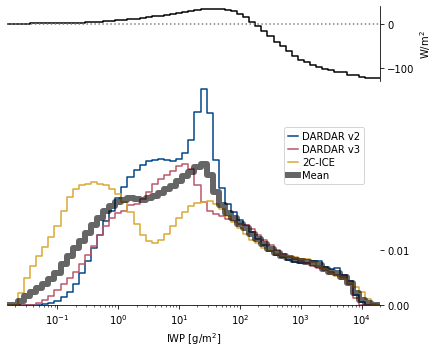

In [20]:
fig = plt.figure(figsize=(6, 5.6/7 * 6), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0,  height_ratios=[1, 2.9])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax = [ax0, ax1]

# Plot of multimodel mean net CRE at 300 K
ds.ncre.mean('model').sel(SST=300).plot.step(ax=ax0, lw=1.5, color='k', label='Net', xscale='log', xlim=(1.5e-2, 2e4), ylim=(-130,40))
ax0.yaxis.set_label_position("right")
ax0.yaxis.tick_right()
for side in ['left','top','bottom']:
    ax0.spines[side].set_visible(False)
ax0.axhline(ls=':', color='tab:grey')
ax0.set_xticks([]), ax0.minorticks_off()
ax0.set_xlabel(''), ax0.set_ylabel('W/m$^2$')
ax0.set_title('')

# Plot of satellite-observed FWP PDFs
sat_colors = [[0,0.27,0.53], [0.73,0.33,0.40], [0.86,0.66,0.20]]
for i in range(ds.dims['product']):
    ds.f_obs.isel(product=i).plot.step(
        ax=ax1, xscale='log', color=sat_colors[i], label=ds.product.values[i],
        xlim=(1.5e-2, 2e4), ylim=(0,0.0395))
ds.f_obs.mean('product').plot.step(ax=ax1, xscale='log', color='k', lw=6, alpha=0.6, label='Mean')
ax1.set_ylabel('')
ax1.set_yticks([0,0.01])
ax1.set_title('')
ax1.set_xlabel(r'IWP [g/m$^2$]')
ax1.yaxis.tick_right()

for side in ['top','right','left']:
    ax1.spines[side].set_visible(False)
ax1.patch.set_alpha(0)
ax1.legend(bbox_to_anchor=[0.73, 0.84], loc='upper left', labelspacing=0.3, handlelength=1, handletextpad=0.4)



## Figure 2
#### $f(IWP)$ simulated by the RCEMIP CRMs

[Text(0, 0.01, '0.01')]

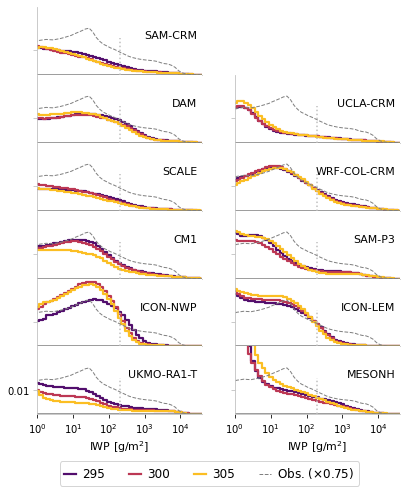

In [21]:
fig, axes = plt.subplots(6, 2, figsize=(6.5,7.5))
fig.subplots_adjust(hspace=0)
axesf = [axes[0,0]] + list(axes[1:,:].flatten())
sstclrs = [mpl.cm.inferno(cval) for cval in [0.24, 0.5, 0.85]]

for i, ax in enumerate(axesf[:ds.dims['model']]):
    for isst in range(ds.dims['SST']):
        ds.f.isel(model=i, SST=isst).plot.step(
            ax=ax, lw=2.2, color=sstclrs[isst], label=str(ds.SST.values[isst]),
            xscale='log', xlim=(1,4e4), ylim=(0,0.028), xticks=[], yticks=[0.01])
    
    # Plot the observational curve (mean PDF of the three obs products)
    scalefac = 0.75
    (0.75 * ds.f_obs.mean('product')).plot(ax=ax, lw=1, ls='--', color=3*[0.5], label=r'Obs. ($\times$0.75)')
    
    ax.axhline(color='tab:grey')
    ax.plot([200,200],[0,0.015], ls=':', color=3*[0.75])
    ax.text(3e4, 0.015, ds.model.values[i], fontsize=11, ha='right')
    ax.set_yticklabels([''])
    ax.tick_params(axis='y', width=0.8, length=4, color=3*[0.75], labelcolor=3*[0])
    ax.set_ylabel('')
    [ax.spines[s].set_color(3*[0.75]) for s in ['bottom','left']]
    [ax.spines[s].set_visible(False) for s in ['top','right']]

for ax in axes[-1,:]:
    ax.set_xlabel('IWP [g/m$^2$]', fontsize=11)
    ax.set_xticks(10**np.arange(0., 5, 1))  
axes[0,1].set_visible(False)
axes[-1, 0].legend(ncol=4, loc='upper left', bbox_to_anchor=[0.1, -0.6], fontsize=12, handlelength=1, handletextpad=0.5)
axes[-1,0].set_yticklabels(['0.01'])


## Figure 3a
#### IWP-resolved changes in cloud amount and their effects on $C(IWP)$

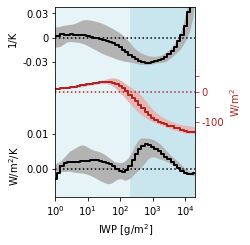

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(2.5, 3.5), sharex=True)
fig.subplots_adjust(hspace=0)

# top: multimodel mean fractional change in f(IWP)
axis = ax[0]
frac.f.mean('model').plot.step(ax=axis, color='k', lw=2, xscale='log', xlim=(1,2e4), ylim=(-0.04, 0.038))
axis.fill_between(ds.fwp,
                  frac.f.quantile(0.25, dim='model').rolling(fwp=3,center=True).mean(),
                  frac.f.quantile(0.75, dim='model').rolling(fwp=3,center=True).mean(),
                  color=3*[0.7], edgecolor='None')
axis.axhline(color='k', ls=':')
axis.set_title('')
axis.spines['bottom'].set_visible(False)
axis.set_yticks([-0.03, 0, 0.03])
axis.set_yticklabels(['-0.03', '0', '0.03'])
axis.set_ylabel('1/K')
axis.set_xlabel('')



# middle: multimodel mean CRE at 295 K
axis = ax[1]
c2 = 'firebrick'
ncre_mean = ds.ncre.sel(SST=295).mean('model')
ncre_p25 = ds.ncre.sel(SST=295).quantile(0.25, dim='model').rolling(fwp=3,center=True).mean()
ncre_p75 = ds.ncre.sel(SST=295).quantile(0.75, dim='model').rolling(fwp=3,center=True).mean()
ncre_mean.plot.step(ax=axis, x='fwp', xscale='log', lw=2, color=c2, xlim=(1,2e4), ylim=(-140,70))
axis.fill_between(ds.fwp.values, ncre_p25, ncre_p75, color=[0.9*255/256,0.8*228/256,0.8*225/256], alpha=1,   edgecolor='None')
axis.axhline(color=c2, ls=':')
axis.set_title('')
axis.yaxis.set_label_position("right")
axis.yaxis.tick_right()
axis.yaxis.label.set_color(c2)
axis.set_yticks([-100, -50, 0, 50])
axis.set_yticklabels(['-100', '', '0', ''])
axis.tick_params(axis='y', colors=c2)
for side in ['top',  'bottom']:
    axis.spines[side].set_visible(False)
axis.set_ylabel('W/m$^2$')
axis.set_xlabel('')

# bottom plot: delta f * CRE    
axis = ax[2]
dfC.mean('model').plot.step(ax=axis, x='fwp', xscale='log', lw=2, color='k', xlim=(1,2e4), ylim=(-0.008,0.01))
axis.fill_between(dfC.fwp,
                  dfC.quantile(0.25,dim='model').rolling(fwp=3,center=True).mean(), 
                  dfC.quantile(0.75,dim='model').rolling(fwp=3,center=True).mean(), 
                  color=3*[0.7],  edgecolor='None')
axis.axhline(color='k', ls=':')
axis.set_title('')
axis.spines['top'].set_visible(False)
axis.set_ylabel('W/m$^2$/K')
axis.set_yticks([0,0.01])
axis.set_xlabel(r'IWP [g/m$^2$]')
axis.set_xticks(10**np.arange(0., 5, 1))

for i, axis in enumerate(ax):
    axis.fill_between([1, 200], [-1e3, -1e3], [1e3, 1e3], color='lightblue', alpha=0.3, zorder=0, edgecolor='None')
    axis.fill_between([200, 1000000], [-1e3, -1e3], [1e3, 1e3], color='lightblue', alpha=0.65, zorder=0, edgecolor='None')


## Figure 3b
#### Fractional changes in $f_{ice}$, $f_{thick}$, and $f_{thin}$ across the ensemble

In [40]:
# first some style details for the boxplots
c2 = [0, 0, 0]
c3 = [0.17, 0.63, 0.17]
c5 = [0.78, 0.08, 0.51]

fliers0 = dict(markerfacecolor=c2, markeredgecolor=c2,  marker='o', markersize=0)
whisk0 = dict(color=c2, lw=1,)
median0 = dict(color=c2, lw=1)
box0 = dict(facecolor=c2, lw=2, edgecolor='None',  alpha=0.3)

fliers1 = dict(markerfacecolor=c3, markeredgecolor=c3,  marker='o', markersize=0)
whisk1 = dict(color=c3, lw=1)
median1 = dict(color=c3, lw=1)
box1 = dict(facecolor=c3,  lw=1, edgecolor='None',  alpha=0.3)

fliers2 = dict(markerfacecolor=c5, markeredgecolor=c5,  marker='o', markersize=0)
whisk2 = dict(color=c5, lw=1)
median2 = dict(color=c5, lw=1)
box2 = dict(facecolor=c5,  lw=1, edgecolor='None',  alpha=0.3)

#n = len(frac.fice)
width = 0.4 # box width

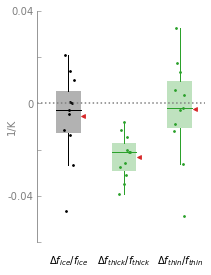

In [46]:
fig, ax = plt.subplots(figsize=(3, 4.25))

xs = []
x = 0.9
field = frac.fice
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk0, whiskerprops=whisk0, flierprops=fliers0, medianprops=median0, boxprops=box0)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values)) #random x values to spread out individual model scatter points
ax.scatter(xscat, field, color=c2, s=3, marker='o')
ax.scatter(x + 0.6*width, field.mean().values, marker='<', color='tab:red', s=14) # multimodel mean
xs.append(x)

x += 0.9
field = frac.fthick
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk1, whiskerprops=whisk1, flierprops=fliers1, medianprops=median1, boxprops=box1)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c3, s=3, marker='o')
ax.scatter(x + 0.6*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

x += 0.9
field = frac.fthin
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk1, whiskerprops=whisk1, flierprops=fliers1, medianprops=median1, boxprops=box1)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c3, s=3, marker='o')
ax.scatter(x + 0.6*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

[ax.spines[side].set_visible(False) for side in ['right', 'bottom', 'top']]
[ax.spines[side].set_color('tab:grey') for side in ['left', 'right', 'bottom', 'top']]

ax.set_xlim(1 - 1.5*width, x+width)
ax.set_ylim(-0.06, 0.04)
ax.set_yticks(np.arange(-0.06, 0.05, 0.02))
ax.set_yticklabels(['', '-0.04','','0','','0.04'])
plt.xticks(xs, labels=[r'$\Delta f_{ice}/f_{ice}$',r'$\Delta f_{thick}/f_{thick}$',r'$\Delta f_{thin}/f_{thin}$'])
ax.tick_params(axis='x', which='major', pad=12)
ax.tick_params(axis='y', width=0.6, length=4, color='tab:grey', labelcolor='tab:grey', direction='in')
ax.tick_params(axis='x', width=0, length=0)
ax.set_ylabel('1/K',  color='tab:grey')
plt.axhline(ls=':', color='tab:grey')
ax.yaxis.set_label_coords(-0.12, 0.5)

## Fig 3c
#### $\Delta_f C_{ice}$ across the ensemble and its decomposition into thick/thin and area/opacity components

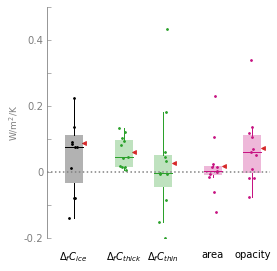

In [50]:
fig, ax = plt.subplots(figsize=(4, 4.25))

xs = []
x = 1
field = dfCice 
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk0, whiskerprops=whisk0, flierprops=fliers0, medianprops=median0, boxprops=box0)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c2, s=3, marker='o')
ax.scatter(x + 0.59*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

x += 1.12
field = dfCthick
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk1, whiskerprops=whisk1, flierprops=fliers1, medianprops=median1, boxprops=box1)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c3, s=3, marker='o')
ax.scatter(x + 0.59*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

x += 0.88
field = dfCthin
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk1, whiskerprops=whisk1, flierprops=fliers1, medianprops=median1, boxprops=box1)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c3, s=3, marker='o')
ax.scatter(x + 0.59*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

x += 1.12
field = area
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk2, whiskerprops=whisk2, flierprops=fliers2, medianprops=median2, boxprops=box2)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c5, s=3, marker='o')
ax.scatter(x + 0.59*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

x += 0.88
field = opacity
ax.boxplot(field, positions=[x], widths=width, patch_artist=True, showcaps=False, capprops=whisk2, whiskerprops=whisk2, flierprops=fliers2, medianprops=median2, boxprops=box2)
xscat = x + np.random.uniform(-width/4, width/4, len(field.values))
ax.scatter(xscat, field, color=c5, s=3, marker='o')
ax.scatter(x + 0.59*width, field.mean().values, marker='<', color='tab:red', s=14)
xs.append(x)

[ax.spines[side].set_visible(False) for side in ['right', 'bottom', 'top']]
[ax.spines[side].set_color('tab:grey') for side in ['left', 'right', 'bottom', 'top']]

ax.set_xlim(1 - 1.5*width, x+width)
ax.set_ylim(-0.2, 0.5)
ax.set_yticks(np.arange(-0.2, 0.6, 0.1))
ax.set_yticklabels(['-0.2', '', '0', '', '0.2', '', '0.4', '' ])
plt.xticks(xs, labels=[r'$\Delta_f C_{ice}$', r'$\Delta_f C_{thick}$', r'$\Delta_f C_{thin}$', 'area', 'opacity' ])

ax.tick_params(axis='x', which='major', pad=12)
ax.tick_params(axis='y', width=0.6, length=4, color='tab:grey', labelcolor='tab:grey', direction='in')
ax.tick_params(axis='x', width=0, length=0)
ax.set_ylabel('W/m$^2/$K', fontsize=9, color='tab:grey')
plt.axhline(ls=':', color='tab:grey')


# Impact on estimates of equilibrium climate sensitivity

First, load output from several runs of the Sherwood et al. (2020) ECS code. This dataset contains statistics from four different runs:
1. WCRP baseline: feedback value from Sherwood et al 2020)
2. RCEMIP_std_dev: mean anvil area feedback from RCEMIP, with uncertainty equal to the standard deviation of the 11 RCEMIP models
3. RCEMIP_full_range: as above, but with uncertainty equal to one half of the full range of the 11-model RCEMIP ensemble
4. RCEMIP_S20: as above, but with uncertainty equal to the originally assessed uncertainty from Sherwood et al 2020.

In [75]:
ecs = xr.open_dataset('ecs_output.nc')
ecs[['anv_area_fdbck_mean', 'anv_area_fdbck_stdev']].to_dataframe()

,anv_area_fdbck_mean,anv_area_fdbck_stdev
case,,
WCRP baseline,-0.2000,0.2000
RCEMIP_std_dev,0.0294,0.0606
RCEMIP_full_range,0.0294,0.1594
RCEMIP_S20,0.0294,0.2000


## Fig 4

Text(5.3, 0.91, 'This study')

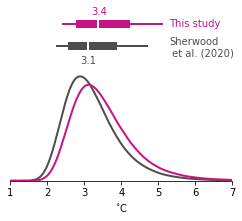

In [76]:
c0 = 3*[0.3]
c1 = [0.78, 0.08, 0.52]

fig, ax = plt.subplots(figsize=(3.425, 2.9))
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.15)
ecs.pdf.isel(case=0).plot(ax=ax, lw=2, color=c0, label='Sherwood et al. baseline', xlim=(1,7), ylim=(0,0.95))
ecs.pdf.isel(case=1).plot(ax=ax, lw=2, color=c1, label='RCEMIP', ls='-')
for side in ['top','right','left']:
    ax.spines[side].set_visible(False)
ax.set_xlabel('$^{\circ}$C')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('')

y1 = 0.77
rect66orig = patches.Rectangle((ecs.p17[0], y1), (ecs.p83-ecs.p17)[0], 0.05, facecolor=c0)
ax.add_patch(rect66orig)
ax.plot([ecs.p5[0], ecs.p95[0]],2*[y1 + 0.025], color=c0, lw=2, zorder=0)
rect50orig = patches.Rectangle((ecs.p50[0]-0.03, y1), (0.06), 0.05, facecolor='w')
ax.add_patch(rect50orig)

y2 = 0.9
rect66rcemip = patches.Rectangle((ecs.p17[1], y2), (ecs.p83-ecs.p17)[1], 0.05, facecolor=c1)
ax.add_patch(rect66rcemip)
ax.plot([ecs.p5[1], ecs.p95[1]],2*[y2 + 0.025], color=c1, lw=2, zorder=0)
rect50rcemip = patches.Rectangle((ecs.p50[1]-0.03, y2), (0.06), 0.05, facecolor='w')
ax.add_patch(rect50rcemip)

ax.text(3.1, y1-0.08, '3.1', ha='center',color=c0)
ax.text(5.3, y1+0.02, 'Sherwood\n et al. (2020)',  color=c0, va='center')
ax.text(3.4, y2+0.08, '3.4',  ha='center',color=c1)
ax.text(5.3, y2+0.01, 'This study',  color=c1)


# Extended Data Fig 9

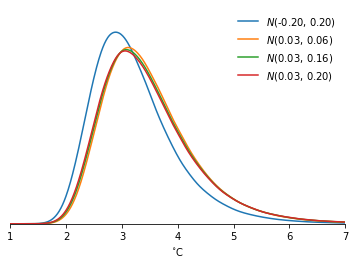

In [87]:
fig, ax = plt.subplots()
ecs.pdf.plot.line(x='bin_centres', xlim=(1,7), ylim=(0,0.7), add_legend=False)
ax.set_xlabel('$^{\circ}$C')
ax.set_ylabel('')
ax.set_yticks([])
ax.set_title('')
for side in ['top','right','left']:
    ax.spines[side].set_visible(False)
case_labels = ['$N$({:.2f}, {:.2f})'.format(ecs.anv_area_fdbck_mean.values[i], ecs.anv_area_fdbck_stdev.values[i]) for i in range(ecs.dims['case'])]
plt.legend(case_labels, frameon=False)
